## Image segmentation with CamVid

**Segmentation** means classification for every single pixel in a pic. 

To build a segmentation model, you would need a dataset where someone has actually labelled every pixel: a lot of work! Probably you are noit going to do it yourself! Very common in medicine, life sciences, automotive, etc. many domain areas in which domain-specific tools exist. We can use a nice dataset, in which a lot os segmented images are available.

ALl details about datasets at: course.fast.ai. You should QUOTE article/people for this!


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

Next cell will download all stuff into:

    [PosixPath('/Users/bonacor/.fastai/data/camvid/images'),
     PosixPath('/Users/bonacor/.fastai/data/camvid/labels'),
     PosixPath('/Users/bonacor/.fastai/data/camvid/codes.txt'),
     PosixPath('/Users/bonacor/.fastai/data/camvid/valid.txt')]

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/Users/bonacor/.fastai/data/camvid/images'),
 PosixPath('/Users/bonacor/.fastai/data/camvid/labels'),
 PosixPath('/Users/bonacor/.fastai/data/camvid/codes.txt'),
 PosixPath('/Users/bonacor/.fastai/data/camvid/valid.txt')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [5]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/Users/bonacor/.fastai/data/camvid/images/0001TP_009030.png'),
 PosixPath('/Users/bonacor/.fastai/data/camvid/images/0001TP_008460.png'),
 PosixPath('/Users/bonacor/.fastai/data/camvid/images/0016E5_08490.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/Users/bonacor/.fastai/data/camvid/labels/Seq05VD_f04560_P.png'),
 PosixPath('/Users/bonacor/.fastai/data/camvid/labels/0001TP_009630_P.png'),
 PosixPath('/Users/bonacor/.fastai/data/camvid/labels/0016E5_08117_P.png')]

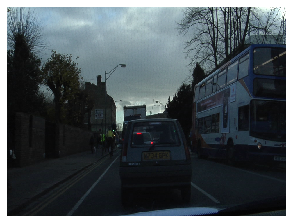

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

Probably the names have a `_P` at the end when they are labels? Just gettins.. let's write a lamdba to handle this;

In [9]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

You need to use `open_mask` and not `open_img` here, if you want to see ther masking. Note that `.show` will recognize it is a mask, and will associate random colours to each area. Note also that this all masking deals with integers, not floating point. 

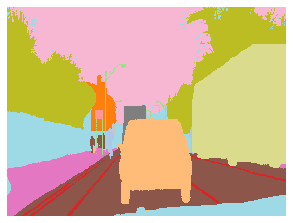

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

We have the segmentation as numbers, the same for the same 'logical' area.

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[30, 30, 30,  ..., 21, 21, 21],
          [30, 30, 30,  ..., 21, 21, 21],
          [30, 30, 30,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30]]]))

Note they gaves us:

    [PosixPath('/Users/bonacor/.fastai/data/camvid/images'),
     PosixPath('/Users/bonacor/.fastai/data/camvid/labels'),
     PosixPath('/Users/bonacor/.fastai/data/camvid/codes.txt'),
     PosixPath('/Users/bonacor/.fastai/data/camvid/valid.txt')]

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

Quite selfexplanatory: take a nb in the tensor, count on the codes and find what that nb refers to (e.g. building, or street, etc).

## Datasets

Time to handle the problem as usual, i.e. create a DataBunch appropriately, etc:

In [13]:
size = src_size//2


In [14]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 0MB of GPU RAM free


There seems to be more than one way to do this today on pytorch.

**WARNING  FIXME this does not work**

In [15]:
# NO

src = (ImageFileList.from_folder(path_img)
       .label_from_func(get_y_fn)
       .split_by_fname_file('../valid.txt'))

NameError: name 'ImageFileList' is not defined

Explanation might be here:
    https://forums.fast.ai/t/name-imagefilelist-is-not-defined-in-fastai-version-1-0-24/30463, but that does not work either. This is what wa

In [23]:
# NO

src = (ImageItemList.from_folder(path_img)
       .label_from_func(get_y_fn)
       .split_by_fname_file('../valid.txt'))

NameError: name 'ImageItemList' is not defined

(go with what's below this point)

Probably they gave us valid.txt so that we do not so it randomly, otherwise we might end up in having pixels close to each other and then it is too easy (FIXME). Also, usually we have string labels, here we do not, and we have to use `classes=codes` to get the labels from a file (the list of what the nbs in the tensor mean).

In [25]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

Specifying `tfm_y=True`, we are telling to trasform also the `y` when we transform the `x`, otherwise flipping a pic and NOT flippin its segmented pic will result in them not matching anymore, i.e. you need to flip both.

In [29]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs,
                   num_workers=0)       # added num_workers=0 (remember it goes where databunch is defined, and close to bs)
        .normalize(imagenet_stats))

Fast.ai understands that this is a segmentation model you are building, and when you ask for a `.show_batch` it colour-codes the images! This is makes way easier to check the ground-truth.

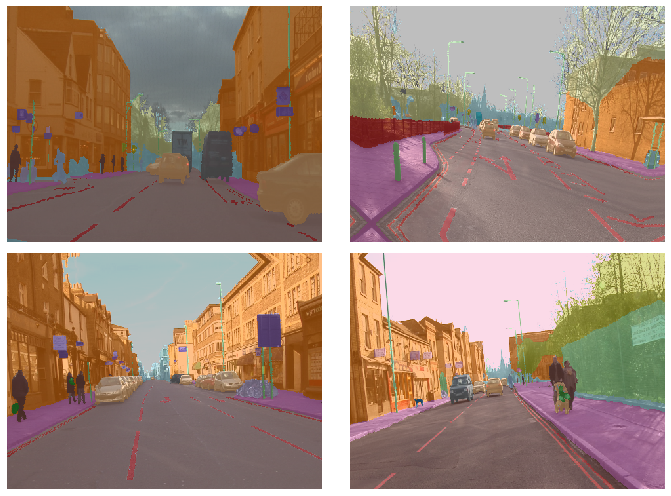

In [30]:
data.show_batch(2, figsize=(10,7))

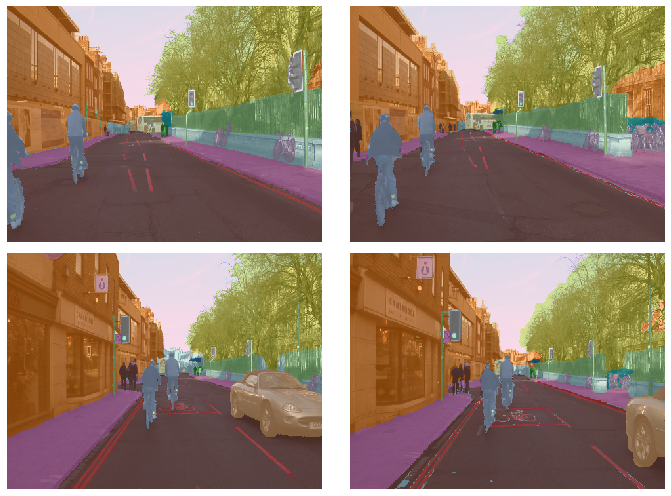

In [31]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics=acc_camvid
# metrics=accuracy

In [ ]:
wd=1e-2

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=3e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

In [ ]:
learn.show_results(rows=3, figsize=(8,9))

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

In [ ]:
learn.save('stage-2');

In [ ]:
please stop

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

## fin